<a href="https://colab.research.google.com/github/infiniteMJ/DeepLearningProject/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [1]:
## mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "drive/MyDrive/DeepLearningProject/rainy_image_dataset.zip" -d  "drive/MyDrive/DeepLearningProject/data/"

# Create Derained Dataset

In [2]:
import os
import os.path
import numpy as np
import torch
import cv2
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from PIL import Image
from skimage import io
from math import ceil

In [36]:
class DerainDataset(Dataset):
    def __init__(self, data_root, ground_truth, rainy, patch_size=0, transform=None):
        super(DerainDataset, self).__init__()
        self.ground_truth = ground_truth
        self.rainy = rainy
        self.gt_path = os.path.join(data_root, ground_truth)
        self.rainy_path = os.path.join(data_root, rainy)
        self.rainy_files = os.listdir(self.rainy_path)
        self.patch_size = patch_size
        self.transform = transform

    def __len__(self):
        return len(self.rainy_files)

    def __getitem__(self, key):
        new_key = key + 1
        idx = ceil(new_key / 14)
        gt_img = Image.open(os.path.join(self.gt_path, str(idx) + '.jpg')).convert('RGB')
        sub = new_key % 14 if new_key % 14 !=0 else 14
        rain_img = Image.open(os.path.join(self.rainy_path, str(idx) + '_' + str(sub) + '.jpg')).convert('RGB')

        if self.transform:
            gt_img = self.transform(gt_img)
            rain_img = self.transform(rain_img)
        else:
            gt_img = transforms.functional.to_tensor(gt_img)
            rain_img = transforms.functional.to_tensor(rain_img)

        if self.patch_size:
            i, j, h, w = transforms.RandomCrop.get_params(
                gt_img, output_size=(self.patch_size, self.patch_size))
            gt_img = TF.crop(gt_img, i, j, h, w)
            rain_img = TF.crop(rain_img, i, j, h, w)

        sample = {
            "ground_truth": gt_img,
            'rain_img': rain_img
        }

        return sample

In [4]:
transform=transforms.Compose([
                              transforms.RandomCrop(64),
                              transforms.ToTensor()
                              ])                   

In [37]:
train_dataset = DerainDataset(data_root='drive/MyDrive/DeepLearningProject/data/training',
                              ground_truth="ground_truth",
                              rainy='rainy_image',
                              patch_size=64)

(3, 64, 64)


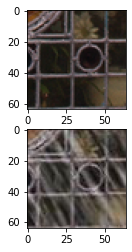

In [38]:
sample = train_dataset[13]
print(sample['ground_truth'].numpy().shape)
plt.subplot(2, 1, 1)
plt.imshow(sample['ground_truth'].numpy().transpose(1, 2, 0))
plt.subplot(2, 1, 2)
plt.imshow(sample["rain_img"].numpy().transpose(1, 2, 0))

In [53]:
print(len(train_dataset))
train_size = int(0.7 * len(train_dataset))
val_size = len(train_dataset) - train_size
print(train_size, val_size)
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

12600
8820 3780


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create base derain net


In [9]:
!pip install guided-filter-pytorch

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from guided_filter_pytorch.guided_filter import GuidedFilter

In [51]:
class DerainNet(nn.Module):
    def __init__(self):
        super(DerainNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 512, (3, 3), padding=2)
        self.conv2 = nn.Conv2d(512, 128, (3, 3), padding=1)
        self.conv3 = nn.Conv2d(128, 3, (3, 3), padding=0)

    def forward(self, image):
        base = GuidedFilter(15, 1)(image, image)
        detail = image - base
        
        y = self.conv1(detail)
        y = F.relu(y)
        y = self.conv2(y)
        y = F.relu(y)
        y = self.conv3(y)

        return y

In [40]:
def train_model(model, criterion, optimizer, n_epochs=20):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf

    for epoch in range(1, n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        # train the model #
        model.train()
        
        for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            rainy, clean = sample_batched['rain_img'].to(device), sample_batched['ground_truth'].to(device)
            label = clean - GuidedFilter(15, 1)(clean, clean)
            # zero the parameter gradients
            optimizer.zero_grad()
            output = model(rainy)
            # calculate loss
            loss = criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        for batch_idx, sample_batched in enumerate(val_dataloader):
            rainy, clean = sample_batched['rain_img'].to(device), sample_batched['ground_truth'].to(device)
            label = clean - GuidedFilter(15, 1)(clean, clean) 
            output = model(rainy)
            # calculate loss
            loss=criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model, 'drive/MyDrive/DL_Project/model.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    return model

In [13]:
from torch import nn, optim

In [54]:
criterion = nn.MSELoss()
model_CNN = DerainNet().to(device)
optimizer = optim.Adam(model_CNN.parameters(), lr=0.01)
model = train_model(model_CNN, criterion, optimizer)

Epoch 1, Batch 1 loss: 0.013754
Epoch 1, Batch 101 loss: 0.493339
Epoch 1, Batch 201 loss: 0.250539
Epoch: 1 	Training Loss: 0.183506 	Validation Loss: 0.003420
Validation loss decreased (inf --> 0.003420).  Saving model ...
Epoch 2, Batch 1 loss: 0.003280
Epoch 2, Batch 101 loss: 0.003248
Epoch 2, Batch 201 loss: 0.003126
Epoch: 2 	Training Loss: 0.003077 	Validation Loss: 0.002978
Validation loss decreased (0.003420 --> 0.002978).  Saving model ...
Epoch 3, Batch 1 loss: 0.002914
Epoch 3, Batch 101 loss: 0.002961
Epoch 3, Batch 201 loss: 0.002932
Epoch: 3 	Training Loss: 0.002851 	Validation Loss: 0.002580
Validation loss decreased (0.002978 --> 0.002580).  Saving model ...
Epoch 4, Batch 1 loss: 0.002334
Epoch 4, Batch 101 loss: 0.002563
Epoch 4, Batch 201 loss: 0.002587
Epoch: 4 	Training Loss: 0.002532 	Validation Loss: 0.002918
Epoch 5, Batch 1 loss: 0.002784
Epoch 5, Batch 101 loss: 0.002486
Epoch 5, Batch 201 loss: 0.002468
Epoch: 5 	Training Loss: 0.002465 	Validation Loss: 0.